In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import itertools
import pickle

from nltk import ngrams

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Conv1D, LSTM, Input, Embedding, Activation, TimeDistributed, Bidirectional, Dropout, Flatten

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
DATASET_PATH = '../../data/ftb1u-v1/sentences'

### Load train data

In [3]:
with open(f'{DATASET_PATH}/train_pos.pkl', 'rb') as f:
    train = pickle.load(f)

In [4]:
train[:5]

[[('Hallituksen', 'NOUN'),
  ('esittämä', 'VERB'),
  ('1,5', 'NUM'),
  ('miljardin', 'NUM'),
  ('leikkaus', 'NOUN'),
  ('ansiosidonnaiseen', 'ADJ'),
  ('työttömyysturvaan', 'NOUN'),
  ('ei', 'VERB'),
  ('tyydytä', 'VERB'),
  (',', 'PUNCT'),
  ('koska', 'SCONJ'),
  ('esitys', 'NOUN'),
  ('ei', 'VERB'),
  ('muuta', 'VERB'),
  ('itse', 'DET'),
  ('järjestelmää', 'NOUN'),
  ('.', 'PUNCT')],
 [('kiehauta', 'VERB'),
  ('ruoka', 'NOUN'),
  ('kotona', 'ADV'),
  (',', 'PUNCT'),
  ('pakkaa', 'VERB'),
  ('kattila', 'NOUN'),
  ('kypsennyslaatikkoon', 'NOUN'),
  (',', 'PUNCT'),
  ('ja', 'CONJ'),
  ('mökillä', 'NOUN'),
  ('voit', 'VERB'),
  ('mennä', 'VERB'),
  ('suoraan', 'ADV'),
  ('ruokapöytään', 'NOUN'),
  ('.', 'PUNCT')],
 [('Hevonen', 'NOUN'),
  ('juosta', 'VERB'),
  ('nulkkaisi', 'VERB'),
  ('Piimätietä', 'PROPN'),
  ('myöten', 'ADP'),
  ('Haapakylään', 'PROPN'),
  ('.', 'PUNCT')],
 [('Nyt', 'ADV'),
  ('ei', 'VERB'),
  ('jouda', 'VERB'),
  ('sairastelemaan', 'VERB'),
  ('.', 'PUNCT')],
 [('Mi

In [5]:
MAX_LENGTH = len(max(train, key=len))
MAX_LENGTH

68

In [6]:
bigram_size = 2

In [7]:
MAX_LENGTH_CHAR = len(max((list(ngrams(t[0], bigram_size)) for sent in train for t in sent), key=len))
MAX_LENGTH_CHAR

36

In [8]:
%%time
train_sentences, train_sentence_tags = [], [] 
for tagged_sentence in train:
    sentence, tags = zip(*tagged_sentence)
    train_sentences.append(np.array(sentence))
    train_sentence_tags.append(np.array(tags))

CPU times: user 57.7 ms, sys: 9.1 ms, total: 66.8 ms
Wall time: 62.7 ms


In [9]:
del train

### Encode data

In [10]:
words, tags = set([]), set([])

l = []
for s in train_sentences:
    for w in s:
        l += [''.join(bg) for bg in set(list(ngrams(w, bigram_size)))]
        if len(w) < bigram_size:
            l += [w.lower()]
bigrams = set(l)
 
for s in train_sentences:
    for w in s:
        words.add(w.lower())

for ts in train_sentence_tags:
    for t in ts:
        tags.add(t)

tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0

char2index = {ch: i + 2 for i, ch in enumerate(list(bigrams))}
char2index['-OOV-'] = 1
char2index['-PAD-'] = 0
char2index[None] = 1

In [11]:
len(char2index), len(tag2index)

(1515, 16)

In [12]:
def encode_sentences(sentences, sentence_tags, max_len=MAX_LENGTH, max_word_len=MAX_LENGTH_CHAR, bigram_size=3):
    chars_X = np.zeros((len(sentences), max_len, max_word_len))
    for i, sentence in enumerate(sentences):
        for j, word in enumerate(sentence):
            if len(word) < bigram_size:
                word_ngrams = [word]
            else:
                word_ngrams = list(ngrams(word, bigram_size))
            
            for k, bg in enumerate(word_ngrams):
                bg = ''.join(bg)
                if j < MAX_LENGTH and k < MAX_LENGTH_CHAR:
                    chars_X[i, j, k] = char2index.get(bg, char2index["-OOV-"])

    tags_y = []
    for s in sentence_tags:
        tags_y.append([tag2index[t] for t in s])
    return chars_X, tags_y

In [13]:
%%time
train_chars_X, train_tags_y = encode_sentences(train_sentences, train_sentence_tags, bigram_size=bigram_size)

CPU times: user 516 ms, sys: 7.74 ms, total: 523 ms
Wall time: 523 ms


### Load test data

In [14]:
with open(f'{DATASET_PATH}/test_pos.pkl', 'rb') as f:
    test = pickle.load(f)

In [15]:
test[:5]

[[('Nyt', 'ADV'),
  ('meidän', 'PRON'),
  ('on', 'VERB'),
  ('lähdettävä', 'VERB'),
  ('.', 'PUNCT')],
 [('Kosto', 'NOUN'), ('elää', 'VERB'), ('!', 'PUNCT')],
 [('Martinin', 'PROPN'),
  ('mielestä', 'ADP'),
  ('hän', 'PRON'),
  ('olisi', 'VERB'),
  ('ansainnut', 'VERB'),
  ('paikan', 'NOUN'),
  ('.', 'PUNCT')],
 [('Tiä', 'NOUN'),
  ('meni', 'VERB'),
  ('tualt', 'ADV'),
  ('alhaalk', 'ADV'),
  ('kautta', 'ADV'),
  ('.', 'PUNCT')],
 [('Maailmaa', 'NOUN'),
  ('ei', 'VERB'),
  ('voida', 'VERB'),
  ('rakentaa', 'VERB'),
  ('niin', 'ADV'),
  (',', 'PUNCT'),
  ('että', 'SCONJ'),
  ('heikoista', 'ADJ'),
  ('tehdään', 'VERB'),
  ('heikompia', 'ADJ'),
  (',', 'PUNCT'),
  ('jotta', 'SCONJ'),
  ('vahvat', 'ADJ'),
  ('vahvistuisivat', 'VERB'),
  ('.', 'PUNCT')]]

In [16]:
%%time
test_sentences, test_sentence_tags = [], [] 
for tagged_sentence in test:
    sentence, tags = zip(*tagged_sentence)
    test_sentences.append(np.array(sentence))
    test_sentence_tags.append(np.array(tags))

CPU times: user 45.1 ms, sys: 4.15 ms, total: 49.3 ms
Wall time: 45.9 ms


In [17]:
del test

In [18]:
%%time
test_chars_X, test_tags_y = encode_sentences(test_sentences, test_sentence_tags, bigram_size=bigram_size)

CPU times: user 189 ms, sys: 8.13 ms, total: 197 ms
Wall time: 197 ms


#### Padding

In [19]:
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

In [20]:
train_tags_y.shape, test_tags_y.shape

((14322, 68), (4775, 68))

### Define model and evaluation functions

In [21]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
batch_size = 64

vocab_char_size = len(char2index)
classes = len(tag2index)

input_size = (MAX_LENGTH, MAX_LENGTH_CHAR,)

dropout = 0.2
lstm_recurrent_dropout = 0.2

In [23]:
# Character Input
char_in = Input(shape=(MAX_LENGTH, MAX_LENGTH_CHAR,), name='char_trigram_input')

# Character Embedding
emb_char = Embedding(input_dim=vocab_char_size, output_dim=64, 
                           input_length=(MAX_LENGTH, MAX_LENGTH_CHAR,), mask_zero=False, name='trigram_embedding')(char_in)

# Use several convolution layers
curr_conv_input = emb_char
curr_conv_input = TimeDistributed(Conv1D(filters=64, kernel_size=8, activation="relu", padding="same"))(curr_conv_input)
curr_conv_input = TimeDistributed(Dropout(dropout))(curr_conv_input)
curr_conv_input = TimeDistributed(Conv1D(filters=32, kernel_size=8, activation="relu", padding="same"))(curr_conv_input)
curr_conv_input = TimeDistributed(Dropout(dropout))(curr_conv_input)
curr_conv_input = TimeDistributed(Conv1D(filters=16, kernel_size=8, activation="relu", padding="same"))(curr_conv_input)
curr_conv_input = TimeDistributed(Dropout(dropout))(curr_conv_input)
conv_output = curr_conv_input

conv_output = TimeDistributed(Flatten())(conv_output)

# Main Model BiLSTM
main_lstm = Bidirectional(LSTM(units=64, return_sequences=True, 
                 dropout=dropout, recurrent_dropout=lstm_recurrent_dropout), 
                 name='main_encoder')(conv_output)

# CRF
out = TimeDistributed(Dense(classes, activation='softmax'), name='main_decoder')(main_lstm)  # output

# Model
model = Model(char_in, out)

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision_m, recall_m, f1_m])

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
char_trigram_input (InputLay [(None, 68, 36)]          0         
_________________________________________________________________
trigram_embedding (Embedding (None, 68, 36, 64)        96960     
_________________________________________________________________
time_distributed (TimeDistri (None, 68, 36, 64)        32832     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 68, 36, 64)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 68, 36, 32)        16416     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 68, 36, 32)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 68, 36, 16)       

### Fit model

In [26]:
history = model.fit(train_chars_X, to_categorical(train_tags_y, len(tag2index)),
                    epochs=15, verbose=1,
                    validation_data=(test_chars_X, to_categorical(test_tags_y, len(tag2index))))

Epoch 1/15
448/448 [==============================] - 140s 313ms/step - loss: 0.2449 - accuracy: 0.9285 - precision_m: 0.9750 - recall_m: 0.8924 - f1_m: 0.9317 - val_loss: 0.1570 - val_accuracy: 0.9473 - val_precision_m: 0.9903 - val_recall_m: 0.9196 - val_f1_m: 0.9536
Epoch 2/15
448/448 [==============================] - 140s 312ms/step - loss: 0.1416 - accuracy: 0.9532 - precision_m: 0.9859 - recall_m: 0.9310 - f1_m: 0.9577 - val_loss: 0.1224 - val_accuracy: 0.9599 - val_precision_m: 0.9842 - val_recall_m: 0.9445 - val_f1_m: 0.9639
Epoch 3/15
448/448 [==============================] - 140s 312ms/step - loss: 0.1144 - accuracy: 0.9629 - precision_m: 0.9830 - recall_m: 0.9494 - f1_m: 0.9659 - val_loss: 0.1009 - val_accuracy: 0.9677 - val_precision_m: 0.9843 - val_recall_m: 0.9561 - val_f1_m: 0.9700
Epoch 4/15
448/448 [==============================] - 140s 312ms/step - loss: 0.0959 - accuracy: 0.9689 - precision_m: 0.9838 - recall_m: 0.9589 - f1_m: 0.9712 - val_loss: 0.0845 - val_accur

### Evaluate train model

In [27]:
scores, acc, p, r, f = model.evaluate(train_chars_X, to_categorical(train_tags_y, len(tag2index)))
scores, acc, p, r, f

448/448 [==============================] - 20s 45ms/step - loss: 0.0186 - accuracy: 0.9943 - precision_m: 0.9952 - recall_m: 0.9935 - f1_m: 0.9944


(0.01864052191376686,
 0.9942848086357117,
 0.995248019695282,
 0.9934593439102173,
 0.9943535923957825)

#### Plot scores

In [28]:
from matplotlib import pyplot as plt

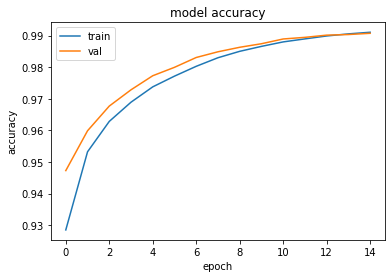

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

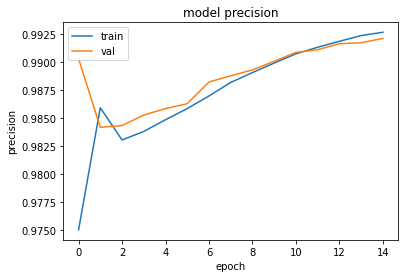

In [30]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

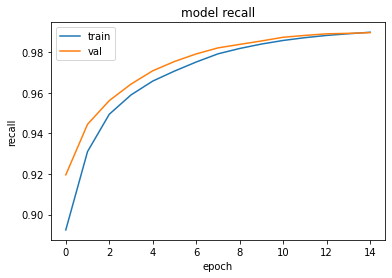

In [31]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

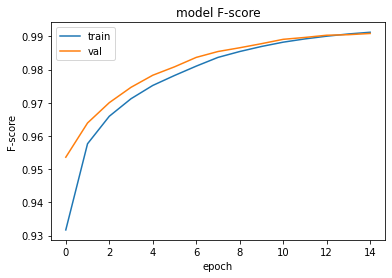

In [32]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model F-score')
plt.ylabel('F-score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

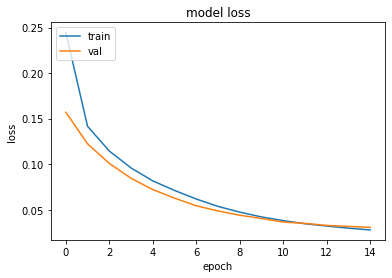

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate test dataset

In [34]:
scores, acc, p, r, f = model.evaluate(test_chars_X, to_categorical(test_tags_y, len(tag2index)))
scores, acc, p, r, f

150/150 [==============================] - 7s 45ms/step - loss: 0.0306 - accuracy: 0.9907 - precision_m: 0.9921 - recall_m: 0.9896 - f1_m: 0.9909


(0.03063168190419674,
 0.9907175898551941,
 0.9920846819877625,
 0.9896335005760193,
 0.9908572435379028)

### Make predictions

In [35]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequences.append([index[cat] for cat in np.argmax(categorical_sequence, axis=1)])
 
    return token_sequences

In [36]:
inverted_tag_index = {i: t for t, i in tag2index.items()}

In [37]:
%%time
predictions = model.predict(test_chars_X)

CPU times: user 48.2 s, sys: 954 ms, total: 49.1 s
Wall time: 7.07 s


In [38]:
%%time
pred_labels = logits_to_tokens(predictions, inverted_tag_index)

CPU times: user 97.6 ms, sys: 0 ns, total: 97.6 ms
Wall time: 96.4 ms


In [39]:
pred_labels[:5]

[['ADV',
  'PRON',
  'VERB',
  'VERB',
  'PUNCT',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-'],
 ['NOUN',
  'VERB',
  'PUNCT',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-P

### Classification report

In [40]:
y_true = [inverted_tag_index[t] for l in test_tags_y for t in l]
y_pred = list(itertools.chain(*pred_labels))

In [41]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       -PAD-       1.00      1.00      1.00    283899
         ADJ       0.88      0.84      0.86      2650
         ADP       0.78      0.83      0.80       720
         ADV       0.90      0.90      0.90      3936
        CONJ       0.98      0.97      0.98      1260
         DET       0.80      0.76      0.78       979
        INTJ       0.90      0.52      0.66        90
        NOUN       0.91      0.92      0.91      9565
         NUM       0.92      0.88      0.90       649
        PRON       0.90      0.93      0.91      2699
       PROPN       0.90      0.87      0.88      1640
       PUNCT       1.00      1.00      1.00      5820
       SCONJ       0.95      0.99      0.97       982
        VERB       0.95      0.95      0.95      9680
           X       0.89      0.52      0.66        63
           _       1.00      0.99      0.99        68

    accuracy                           0.99    324700
   macro avg       0.92   

### Build confusion matrices

In [42]:
labels = list(sorted(set(y_true)))
array = confusion_matrix(y_true=y_true, y_pred=y_pred)

Precision

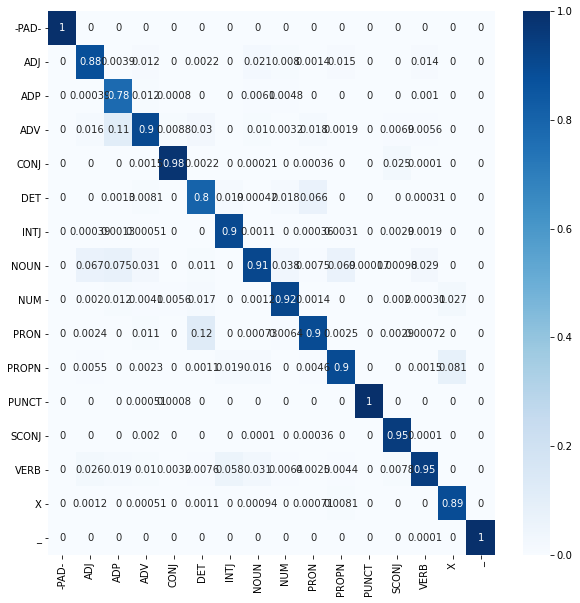

In [43]:
df_cm_1 = pd.DataFrame(array / array.sum(axis=0), index = labels, columns = labels)

plt.figure(figsize = (10,10))
sns.heatmap(df_cm_1, annot=True, cmap=plt.cm.Blues)
plt.show() 

Recall

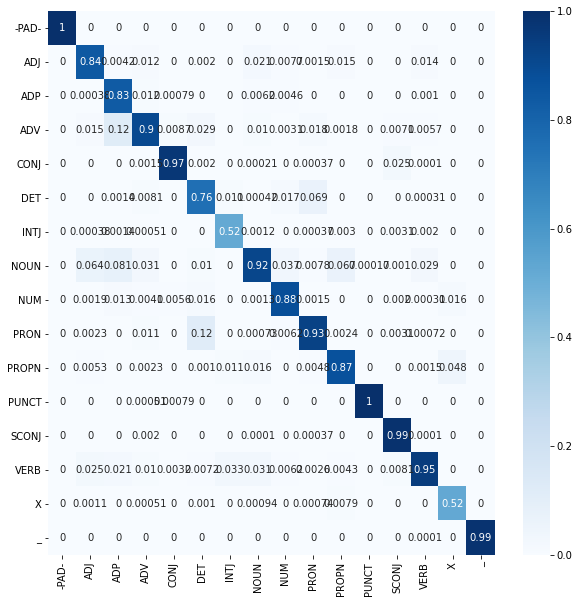

In [44]:
df_cm_2 = pd.DataFrame(array / array.sum(axis=1), index = labels, columns = labels)

plt.figure(figsize = (10,10))
sns.heatmap(df_cm_2, annot=True, cmap=plt.cm.Blues)
plt.show()

### Save POS-tagger

In [45]:
MODEL_PATH = '../../models/ftb1u-bigram-emb-cnns-bilstm-pos-tagger-v1.h5'

In [46]:
model.save(filepath=MODEL_PATH)